In [1]:
import numpy as np
import pandas as pd
import re
import string
from string import digits
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras_preprocessing import sequence

#from keras.layers import Input, LSTM, Embedding, Dense
#from keras.models import Model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [2]:
data = pd.read_table('C:/Projects/NLP/Data/english-french.txt', names=['English','French'])

# insufficent memory when we use the entire data.
data = data[0:25000]
data.shape

(25000, 2)

In [3]:
data.sample(10)

,English,French
13336,I know the drill.,Je connais la chanson.
13992,It just came out.,Ça vient de paraître.
17203,I just remembered.,Je viens de me le rappeler.
24617,You're very lonely.,Vous êtes très solitaire.
13608,I wanted to come.,Je voulais venir.
23778,We were very tired.,Nous étions très fatiguées.
22483,Lesson Two is easy.,La leçon deux est facile.
20070,You're too skinny.,Vous êtes trop maigrichonnes.
6595,Come back home.,Rentre à la maison.
1935,I am a cook.,Je suis cuisinier.


# Preprocessing

In [4]:
data.English = data.English.apply(lambda e: e.lower())
data.French = data.French.apply(lambda f: f.lower())

In [5]:
data.English = data.English.apply(lambda e: re.sub("'", '', e)).apply(lambda e: re.sub(",", ' COMMA', e))
data.French = data.French.apply(lambda f: re.sub("'", '', f)).apply(lambda f: re.sub(",", ' COMMA', f))

In [6]:
# Remove all the special characters punctuation
remove = set(string.punctuation)

data.English = data.English.apply(lambda e: ''.join(ch for ch in e if ch not in remove))
data.French = data.French.apply(lambda f: ''.join(ch for ch in f if ch not in remove))

In [7]:
# Remove digits
delete_digits = str.maketrans('', '', digits)

data.English = data.English.apply(lambda e: e.translate(delete_digits))
data.French = data.French.apply(lambda f: f.translate(delete_digits))

In [8]:
data.sample(10)

,English,French
24309,you look satisfied,vous avez lair satisfait
16224,do you ever sleep,vous arrivetil de dormir
12866,hes a grown man,cest un adulte
12510,dont pick it up,ne le ramasse pas
1340,its a fad,cest une passade
4125,try to sleep,essayez de dormir
9119,call the police,appelez la police
21973,im about to leave,je suis sur le point de partir
12106,youre so wrong,tu as tellement tort
12483,dont be alarmed,ne soyez pas alarmées


In [9]:
# add START and END tokens to target sequences
data.French = data.French.apply(lambda f: "START_ "+ f + " _END")

In [10]:
data.sample(10)

,English,French
17621,i wont sign this,START_ je ne signerai pas ceci _END
20079,youre very brave,START_ tu es très courageux _END
17436,i remember it now,START_ je me le rappelle COMMA maintenant _END
8358,theyre coming,START_ ils sont en train darriver _END
14983,tom is a monster,START_ tom est un monstre _END
21598,i made a few calls,START_ jai passé quelques appels _END
2265,im jealous,START_ je suis jalouse _END
11400,this is rubbish,START_ cest du déchet _END
15667,you have no idea,START_ vous nen avez aucune idée _END
15858,youre resilient,START_ tu es endurant _END


In [11]:
# Vocabulary of English
all_eng_words=set()
for e in data.English:
    for word in e.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
            
# Vocabulary of French 
all_french_words=set()
for f in data.French:
    for word in f.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [12]:
len(all_eng_words), len(all_french_words)

(3969, 8355)

In [13]:
#max length of source sequences

eng_max_length=[]

for e in data.English:
    eng_max_length.append(len(e.split(' ')))

np.max(eng_max_length)

6

In [14]:
# max length of target sequence

fr_max_length = []

for f in data.French:
    fr_max_length.append(len(f.split(' ')))
    
np.max(fr_max_length)

14

In [15]:
input_words = sorted(list(all_eng_words))
output_words = sorted(list(all_french_words))

encoder_tokens = len(all_eng_words)
decoder_tokens = len(all_french_words)

encoder_tokens, decoder_tokens

(3969, 8355)

In [16]:
input_token_index = dict([(word, i) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i) for i, word in enumerate(output_words)])

In [17]:
encoder_input_data = np.zeros((len(data.English), np.max(eng_max_length)), dtype='float32')

decoder_input_data = np.zeros((len(data.French), np.max(fr_max_length)), dtype='float32')
decoder_target_data = np.zeros((len(data.French), np.max(fr_max_length), decoder_tokens), dtype='float32')

In [18]:
for i, (input_text, output_text) in enumerate (zip(data.English, data.French)):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
        
    for t, word in enumerate(output_text.split()):
        decoder_input_data[i, t] = target_token_index[word]
        
        if t>0:
            # decoder_target_data will be ahead by one timestep and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[word]] = 1

# Encoder-Decoder Model

In [19]:
embedding_size = 50

Encoder model

In [20]:
encoder_inputs = Input(shape=(None,))
en_x =  Embedding(encoder_tokens, embedding_size)(encoder_inputs)

encoder = LSTM(50, return_state=True)
encoder_outputs, state_h, state_c = encoder(en_x)

# We discard `encoder_outputs` and only keep hidden and cell states.
encoder_states = [state_h, state_c]

Decoder model

In [21]:
# Set up the decoder, using `encoder_states` as initial state.

decoder_inputs = Input(shape=(None,))
dex =  Embedding(decoder_tokens, embedding_size)
final_dex = dex(decoder_inputs)

decoder_lstm = LSTM(50, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(final_dex, initial_state=encoder_states)

decoder_dense = Dense(decoder_tokens, activation='softmax')

decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 50)     198450      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     417750      input_2[0][0]                    
______________________________________________________________________________________________

# Plot Model

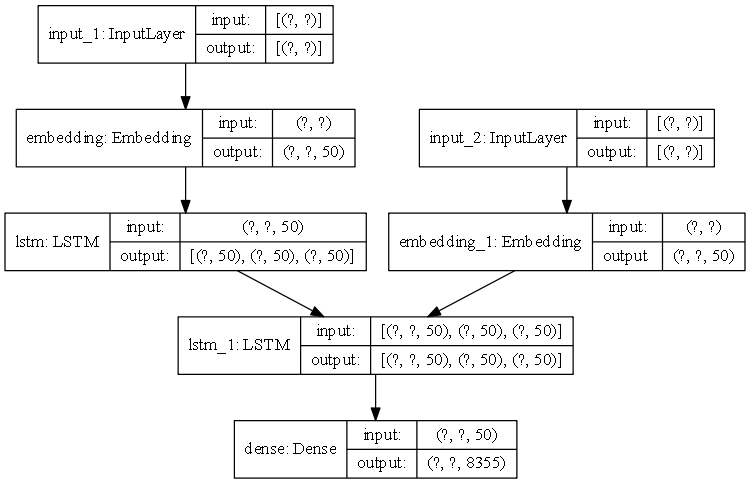

In [22]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

# Compile Model

In [23]:
METRICS = [keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn'), 
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=METRICS)

# Train Model

In [24]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                                        patience=3, verbose=1, mode='auto')

BATCH_SIZE = 8
EPOCHS = 15

model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                                                    batch_size=BATCH_SIZE, epochs=EPOCHS, 
                                                    validation_split=0.5,
                                                    callbacks=[early_stopping_callback])

Train on 12500 samples, validate on 12500 samples
Epoch 1/15
12500/12500 [==============================] - 5416s 433ms/sample - loss: 1.5917 - tp: 8710.0000 - fp: 70269.0000 - tn: 1461986048.0000 - fn: 45742.0000 - accuracy: 0.9999 - precision: 0.1103 - recall: 0.1600 - auc: 0.7656 - val_loss: 1.9134 - val_tp: 12793.0000 - val_fp: 17656.0000 - val_tn: 1462027008.0000 - val_fn: 51543.0000 - val_accuracy: 1.0000 - val_precision: 0.4201 - val_recall: 0.1988 - val_auc: 0.7575
Epoch 2/15
12500/12500 [==============================] - 5883s 471ms/sample - loss: 1.3909 - tp: 13501.0000 - fp: 22814.0000 - tn: 1462032256.0000 - fn: 40951.0000 - accuracy: 1.0000 - precision: 0.3718 - recall: 0.2479 - auc: 0.7947 - val_loss: 1.8284 - val_tp: 14208.0000 - val_fp: 28038.0000 - val_tn: 1462016512.0000 - val_fn: 50128.0000 - val_accuracy: 1.0000 - val_precision: 0.3363 - val_recall: 0.2208 - val_auc: 0.7731
Epoch 3/15
12500/12500 [==============================] - 5793s 463ms/sample - loss: 1.3169 -

In [25]:
model.save('C:/Projects/NLP/Data/Seq2Seq.h5')

# Inference Model

In [32]:
# Encoder inference model
encoder_model_inf = Model(encoder_inputs, encoder_states)

# Decoder inference model
decoder_state_input_h = Input(shape=(None,))
decoder_state_input_c = Input(shape=(None,))
decoder_input_states = [decoder_state_input_h, decoder_state_input_c]

decoder_out, decoder_h, decoder_c = decoder_lstm(final_dex, initial_state=decoder_input_states)

decoder_states = [decoder_h , decoder_c]

decoder_out = decoder_dense(decoder_out)

decoder_model_inf = Model(inputs=[decoder_inputs] + decoder_input_states,
                          outputs=[decoder_out] + decoder_states )

In [34]:
decoder_model_inf.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     417750      input_2[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [91]:
# maximum english sentence length
eng_sentence_length = max([len(sample.split()) for sample in data.English])
# maximum french sentence length
frn_sentence_length = max([len(sample.split()) for sample in data.French])

In [180]:
def decode_seq(inp_seq):
    
    encoder_states = encoder_model_inf.predict(inp_seq)
 
    target_seq = np.zeros(( 1, 1))
    target_seq[0,0] = target_token_index['START_']
    
    stop = False
  
    sentence = ""
  
    while(not stop):
        decoder_out, decoder_h, decoder_c = decoder_model_inf.predict([target_seq] + encoder_states)
        val_index  = np.argmax(decoder_out[0,-1,:])

        #sampled_word = target_token_index[op_id]
        sampled_word = [x for x in target_token_index if target_token_index[x] == val_index][0]
        sentence+=" "+sampled_word    
    
        if (sampled_word == "_END" or len(sentence.split()) >= frn_sentence_length):
            stop = True
        target_seq = np.zeros(( 1, 1))
        target_seq[0,0] =  val_index    
        encoder_states = [decoder_h, decoder_c]
    
    return sentence

In [184]:
for seq_index in range(5):
    inp_seq = encoder_input_data[seq_index : seq_index+1]
    translated_sent = decode_seq(inp_seq)
    
    print('-'*50)
    print('Input sentence:', data.English[seq_index])
    print('Decoded sentence:', translated_sent)

--------------------------------------------------
Input sentence: go
Decoded sentence:  me _END
--------------------------------------------------
Input sentence: run
Decoded sentence:  ai as de moi _END
--------------------------------------------------
Input sentence: run
Decoded sentence:  ai as de moi _END
--------------------------------------------------
Input sentence: wow
Decoded sentence:  me suis _END
--------------------------------------------------
Input sentence: fire
Decoded sentence:  soyez en train de été maison _END
